# Immersed Boundary Method
---

### Author: Marin Lauber

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import NSsolver as ns
try:
    plt.style.use("jupyter")
except OSError:
    print("Delaut syle in use")

Charles S Peskin (1972) developed the immersed boundary method (IBM) to tackle the problem of heart valves. Dirac delta function source terms impose the kinematic boundary condition in the fluid by regularizing a force density on the background mesh

\begin{equation}
\begin{split}
    &\frac{\partial \vec{u}}{\partial t} + (\vec{u}\cdot\nabla)\vec{u} = -\nabla p + \frac{1}{Re}\nabla^2\vec{u} + \int\vec{f}(\vec{\xi}(s, t))\delta_h(\vec{\xi} - \vec{x}) \text{ d}\vec{x},\\
    &\nabla\cdot\vec{u} = 0,\\
    &\vec{u}(\vec{\xi}(s, t)) = \int_{\vec{x}}\vec{u}(\vec{x})\delta(\vec{x} - \vec{\xi} ) \text{ d}\vec{x} = \vec{u}_B(\vec{\xi}(s, t)).
\end{split}
\end{equation}

A constitutional relationship, Hooke’s law, is used to derive this force density based on the motion of the filament, convected by the fluid. Different discrete Dirac delta function can be used within the IBM (three point delta function)

\begin{equation}
\delta_h(r) = \begin{cases}
    \frac{1}{6\Delta r}\left[ 5-3\frac{|r|}{\Delta r} -\sqrt{-3\left(1-\frac{|r|}{\Delta r}\right)^2 +1}\right] & \text{for  } 0.5\Delta r \le |r| \le 1.5\Delta r\\
    \frac{1}{3\Delta r}\left[ 1+\sqrt{-3\left(\frac{r}{\Delta r}\right)^2 +1}\right] & \text{for  } |r| \le 0.5\Delta r\\
    0 & \text{else}
       \end{cases}
\end{equation}

or the 3-point kernel (used in the following) 

\begin{equation}
\delta_h(r) = \begin{cases}
    \frac{4}{3} - r^2 & \text{for  } |r| \le 1.5\\
    5(2.25-3|d|+r^2)&\text{for  } |r| \le 0.5\\
    0 & \qquad \text{else}
       \end{cases}
\end{equation}

In [12]:
def kernel(d):
    return np.where(abs(d)<=.5, .75-d**2, np.where(abs(d)<=1.5,.5*(2.25-3*abs(d)+d**2), 0))

def Ic(x, X, dx, f):
    # interpolation operator
    return np.sum(f*kernel((X - x)/dx))

def Sc(x, X, F, ds=1):
    # spreading operator
    return kernel((X - x)/dx)*ds*F

def f(x, X, u, V, dx, dt, rho):
    # interpolate to Lagrangian point
    Ur = Ic(x, X, dx, u)
    # compute Lagrangian force density
    F = rho/dt*(V - Ur)
    return Sc(x, X, F) # extrapolate to Eulerian points

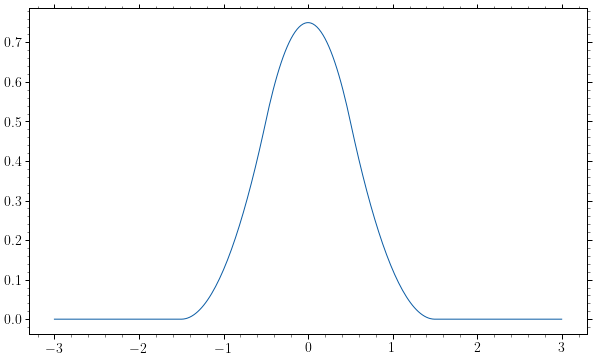

In [13]:
d = np.linspace(-3,3,256)
plt.plot(d, kernel(d));

We use a fractional-step algorithm to solve the following system of equations. 

\begin{split}
    u^* &= r_{\Delta t}(u^n) +  \Delta t \mathcal{S}_c[\xi - x](\mathcal{I}_c[\xi-x](u^n)),\\
    \nabla\cdot(\nabla p) &= \nabla\cdot u^*,\\
    u^{n+1} &= u^* - \frac{\Delta t}{\rho}\nabla p.
\end{split}

where $\mathcal{S}_c$ and $\mathcal{I}_c$ are the spreading and interpolation kernels.

In [15]:
def update(x, X, u0, V, dx, dt=1, rho=1, Nsteps=1):
    
    u_n = u0
    
    for i in range(Nsteps):
        
        # first step
        u_1 = u_n + dt*ns.r(u_n)
        u_star = u_1 + dt*f(x, X, u_1, V, dx, dt, rho)

        sigma = ns.div(u_star, dx)

        p = ns.solve_pressure(np.ones_like(sigma), sigma, dx, verbose=True)

        u_n = u_star - dt/rho*(ns.grad(p, dx))
    
    return u_star, sigma, p, u_n

In [16]:
N = 32
x, dx = np.linspace(-1, 1, N, retstep=True)
xs = x + 0.5*dx # scalar cell-centred values
X = 0.0
V = 1
u0 = np.zeros_like(x)
dt = 1.

us, sigma, p, u_n = update(x, X, u0, V, dx, dt)
print("Interface at X: %.2f" % X)
print(r"L inf: %.3e" % np.max(np.abs(u_n -  V)))

Jacobi solver:
	res0: 3.425e-01
 	res: 3.390e-11
 	iter: 548
Interface at X: 0.00
L inf: 9.688e-01


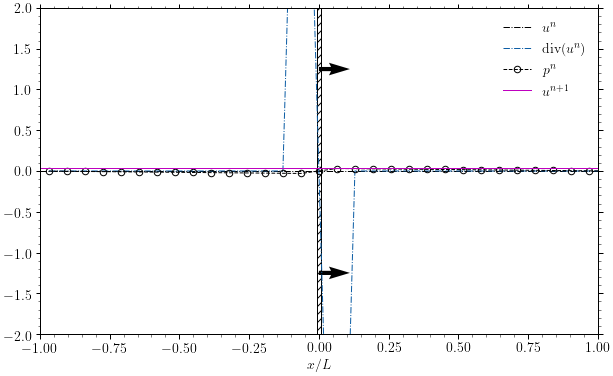

In [17]:
ns.draw_results(x, xs, X, u0, u_n, p, sigma)

Clearly, the correct pressure is not obtained with a single step of the fractional-step method. In fact any number of sub-iteration of this sytem fails to capture the correct pressure (and thus solution).